In [22]:
import pandas as pd
import json
import os
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns
import novelpy
import requests
import tqdm
import numpy as np

In [10]:
def get_openalex_data(query, num_results=1250):
    base_url = "https://api.openalex.org/works"
    results = []
    per_page = 15
    
    for offset in range(0, num_results, per_page):
        response = requests.get(f"{base_url}?filter=title.search:{query},from_publication_date:2007-01-01,to_publication_date:2024-12-31&per-page={per_page}&page={offset // per_page + 1}")
        if response.status_code == 200:
            data = response.json()['results']
            results.extend(data)
        else:
            print(f"Erreur : {response.status_code}")
            break
        if len(data) < per_page:
            break

    return results

def generate_int_id(string_id):
    """Generate a unique integer ID from a string ID using hashing"""
    return int(hashlib.sha256(string_id.encode('utf-8')).hexdigest(), 16) % (10**8)

def prepare_data_for_novelpy(data):
    prepared_data = []
    for item in data:
        try:
            if 'id' not in item:
                print(f"Skipping item without id: {item}")
                continue

            year = item.get('publication_year', None)
            if year is None or not (2007 <= year <= 2024):
                print(f"Skipping item outside date range: {item['id']}")
                continue

            authorships = item.get('authorships', [])
            authors = [author['author']['display_name'] for author in authorships]
            institutions = []
            for author in authorships:
                if 'institutions' in author:
                    for inst in author['institutions']:
                        institutions.append(inst.get('display_name', ''))

            entry = {
                "PMID": generate_int_id(item['id']),
                "year": year,
                "type": item.get('type', ''),
                "num_citations": item.get('cited_by_count', 0),
                "num_authors": len(authorships),
                "authors": authors,
                "institutions": institutions,
                "c04_referencelist": [{"item": generate_int_id(ref)} for ref in item.get('referenced_works', [])],
                "subfield": item.get('concepts', [{}])[0].get('display_name', '') if item.get('concepts') else '',
                "field": item.get('concepts', [{}])[1].get('display_name', '') if len(item.get('concepts', [])) > 1 else '',
                "domain": item.get('concepts', [{}])[2].get('display_name', '') if len(item.get('concepts', [])) > 2 else '',
                "sustainable_development_goals": item.get('sustainable_development_goals', [])
            }
            prepared_data.append(entry)
        except KeyError as e:
            print(f"KeyError: {e} in item {item.get('id', 'unknown')}")
            continue
    return prepared_data

def save_data_by_year(prepared_data, base_dir='Data/docs/references_sample'):
    data_by_year = {}
    for item in prepared_data:
        year = item['year']
        if year not in data_by_year:
            data_by_year[year] = []
        data_by_year[year].append(item)
    
    os.makedirs(base_dir, exist_ok=True)
    for year, data in data_by_year.items():
        with open(os.path.join(base_dir, f"{year}.json"), 'w') as f:
            json.dump(data, f, indent=4)

def validate_data(prepared_data):
    all_ids = set(item['PMID'] for item in prepared_data)
    valid = True
    for item in prepared_data:
        for ref in item['c04_referencelist']:
            if ref['item'] not in all_ids:
                print(f"Reference {ref['item']} in document {item['PMID']} does not exist in the dataset.")
                valid = False
    return valid

query = "sustainable development goals"
data = get_openalex_data(query, num_results=1250)
prepared_data = prepare_data_for_novelpy(data)
save_data_by_year(prepared_data)

Calcul de la matrice de cooccurence et de l'indicateur de Lee et al. (2015):

In [6]:
ref_cooc = novelpy.utils.cooc_utils.create_cooc(
    collection_name="references_sample",
    year_var="year",
    var="c04_referencelist",
    sub_var="item",
    time_window=range(2011, 2024),
    weighted_network=True, 
    self_loop=True
)
ref_cooc.main()

focal_years = range(2011, 2024)
collection_name = 'references_sample'
id_variable = 'PMID'
year_variable = 'year'
variable = 'c04_referencelist'
sub_variable = 'item'

for focal_year in tqdm.tqdm(focal_years, desc="Computing Lee indicator for window of time"):
    Lee = novelpy.indicators.Lee2015(
        collection_name=collection_name,
        id_variable=id_variable,
        year_variable=year_variable,
        variable=variable,
        sub_variable=sub_variable,
        focal_year=focal_year,
        density=True
    )
    Lee.get_indicator()

Computing Lee indicator for window of time:   0%|          | 0/13 [00:00<?, ?it/s]

loading cooc for focal year 2011
cooc loaded !
loading items for papers in 2011


get_papers_item: 100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]


items_loaded !
Getting score per year ...


c:\Users\valen\anaconda3\envs\novelpy\lib\site-packages\scipy\sparse\_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)


Matrice done !
Getting score per paper ...


Computing Lee indicator for window of time:   8%|▊         | 1/13 [02:22<28:33, 142.75s/it]

saved
Done !
loading cooc for focal year 2012
cooc loaded !
loading items for papers in 2012


get_papers_item: 100%|██████████| 3/3 [00:00<00:00, 3004.52it/s]

items_loaded !
Getting score per year ...


Matrice done !
Getting score per paper ...


Computing Lee indicator for window of time:  15%|█▌        | 2/13 [04:45<26:10, 142.82s/it]

saved
Done !
loading cooc for focal year 2013
cooc loaded !
loading items for papers in 2013


get_papers_item: 100%|██████████| 4/4 [00:00<?, ?it/s]

items_loaded !
Getting score per year ...


Matrice done !
Getting score per paper ...


Computing Lee indicator for window of time:  23%|██▎       | 3/13 [07:15<24:18, 145.89s/it]

saved
Done !
loading cooc for focal year 2014
cooc loaded !
loading items for papers in 2014


get_papers_item: 100%|██████████| 17/17 [00:00<00:00, 17029.66it/s]


items_loaded !
Getting score per year ...
Matrice done !
Getting score per paper ...


Computing Lee indicator for window of time:  31%|███       | 4/13 [09:46<22:14, 148.23s/it]

saved
Done !
loading cooc for focal year 2015
cooc loaded !
loading items for papers in 2015


get_papers_item: 100%|██████████| 46/46 [00:00<00:00, 45981.41it/s]

items_loaded !
Getting score per year ...


Matrice done !
Getting score per paper ...


Computing Lee indicator for window of time:  38%|███▊      | 5/13 [12:15<19:47, 148.40s/it]

saved
Done !
loading cooc for focal year 2016
cooc loaded !
loading items for papers in 2016


get_papers_item: 100%|██████████| 105/105 [00:00<00:00, 35033.17it/s]

items_loaded !
Getting score per year ...


Matrice done !
Getting score per paper ...


Computing Lee indicator for window of time:  46%|████▌     | 6/13 [14:52<17:39, 151.39s/it]

saved
Done !
loading cooc for focal year 2017
cooc loaded !
loading items for papers in 2017


get_papers_item: 100%|██████████| 128/128 [00:00<00:00, 64004.64it/s]

items_loaded !
Getting score per year ...


Matrice done !
Getting score per paper ...


Computing Lee indicator for window of time:  54%|█████▍    | 7/13 [17:40<15:39, 156.58s/it]

saved
Done !
loading cooc for focal year 2018
cooc loaded !
loading items for papers in 2018


get_papers_item: 100%|██████████| 186/186 [00:00<00:00, 30991.16it/s]


items_loaded !
Getting score per year ...
Matrice done !
Getting score per paper ...


Computing Lee indicator for window of time:  62%|██████▏   | 8/13 [20:59<14:10, 170.11s/it]

saved
Done !
loading cooc for focal year 2019
cooc loaded !
loading items for papers in 2019


get_papers_item: 100%|██████████| 198/198 [00:00<00:00, 66010.03it/s]

items_loaded !
Getting score per year ...


Matrice done !
Getting score per paper ...


Computing Lee indicator for window of time:  69%|██████▉   | 9/13 [24:18<11:56, 179.22s/it]

saved
Done !
loading cooc for focal year 2020
cooc loaded !
loading items for papers in 2020


get_papers_item: 100%|██████████| 234/234 [00:00<00:00, 43784.22it/s]

items_loaded !
Getting score per year ...


Matrice done !
Getting score per paper ...


Computing Lee indicator for window of time:  77%|███████▋  | 10/13 [27:52<09:29, 189.96s/it]

saved
Done !
loading cooc for focal year 2021
cooc loaded !
loading items for papers in 2021


get_papers_item: 100%|██████████| 201/201 [00:00<00:00, 25113.35it/s]

items_loaded !
Getting score per year ...


Matrice done !
Getting score per paper ...


Computing Lee indicator for window of time:  85%|████████▍ | 11/13 [32:15<07:04, 212.47s/it]

saved
Done !
loading cooc for focal year 2022
cooc loaded !
loading items for papers in 2022


get_papers_item: 100%|██████████| 113/113 [00:00<00:00, 37508.42it/s]

items_loaded !
Getting score per year ...


Matrice done !
Getting score per paper ...


Computing Lee indicator for window of time:  92%|█████████▏| 12/13 [35:42<03:30, 210.74s/it]

saved
Done !
loading cooc for focal year 2023
cooc loaded !
loading items for papers in 2023


get_papers_item: 100%|██████████| 25/25 [00:00<00:00, 24678.18it/s]

items_loaded !
Getting score per year ...


Matrice done !
Getting score per paper ...


Computing Lee indicator for window of time: 100%|██████████| 13/13 [38:24<00:00, 177.24s/it]

saved
Done !


c:\Users\valen\anaconda3\envs\novelpy\lib\site-packages\pandas\core\internals\construction.py:308: UserWarning: Warning: converting a masked element to nan.
  values = np.array([convert(v) for v in values])


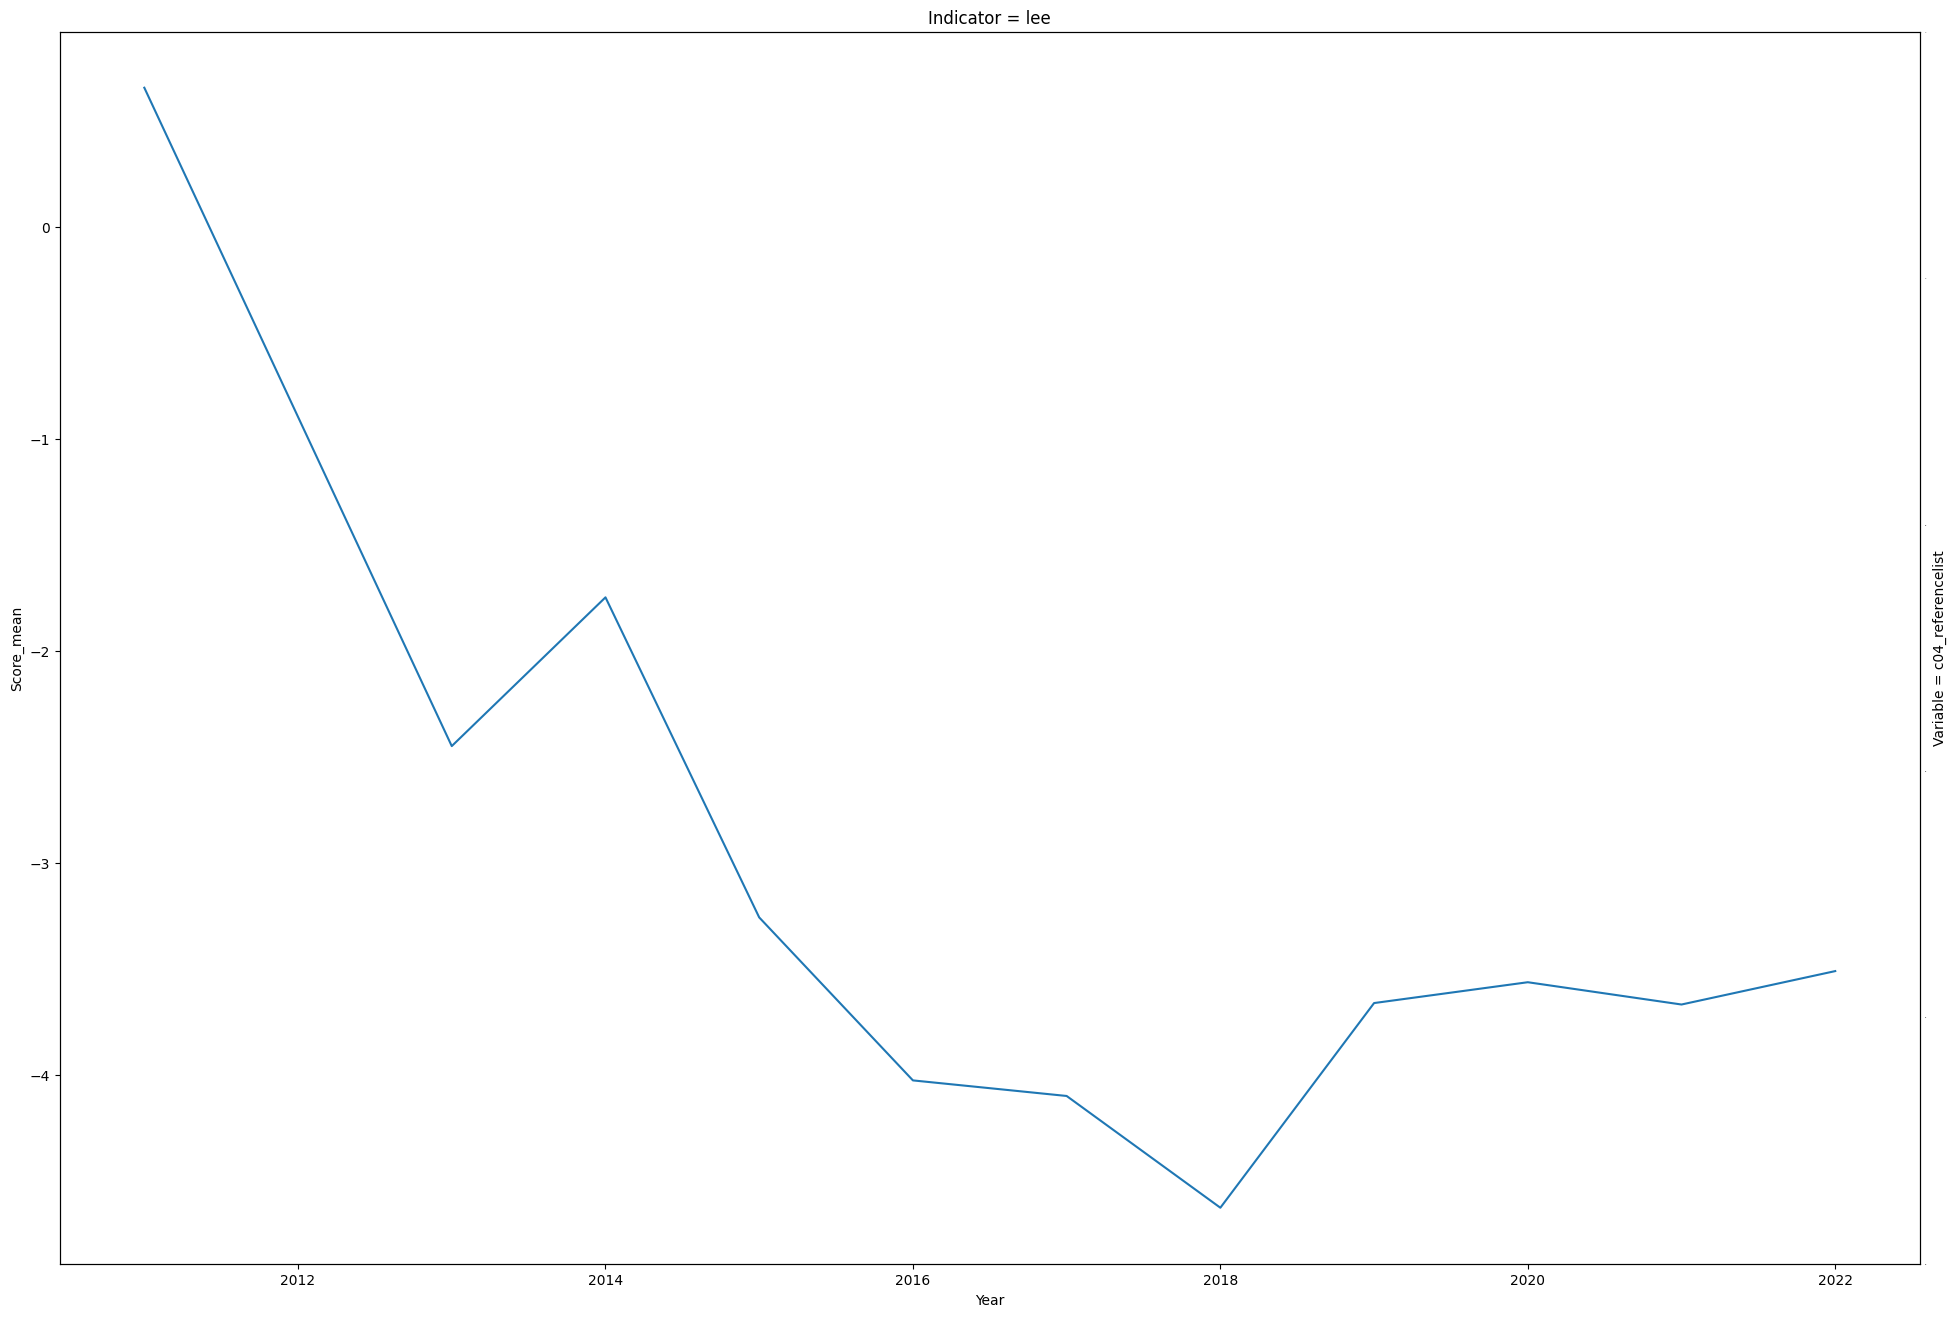

In [7]:
trend = novelpy.utils.novelty_trend(
    year_range=range(2011, 2023, 1),
    variables=["c04_referencelist"],
    id_variable="PMID",
    indicators=["lee"]
)

trend.get_plot_trend()

In [8]:
#Récupération sous format csv du commonness
def convert_to_dataframe(data):
    records = []
    for item in data:
        pmid = item.get('PMID', None)
        year = item.get('year', None)
        novelty_score = item.get('c04_referencelist_lee', {}).get('score', {}).get('novelty', None)
        records.append({
            'PMID': pmid,
            'Year': year,
            'Novelty': novelty_score
        })
    return pd.DataFrame(records)

def load_data_from_files(start_year, end_year, directory):
    all_data = []
    for year in range(start_year, end_year + 1):
        file_path = os.path.join(directory, f"{year}.json")
        if os.path.exists(file_path):
            with open(file_path, 'r') as f:
                data = json.load(f)
                all_data.extend(data)
                print(f"Data from {year}.json loaded successfully")
        else:
            print(f"File {file_path} does not exist")
    return all_data

def convert_to_dataframe(data):
    records = []
    for item in data:
        pmid = item.get('PMID', None)
        novelty_score = item.get('c04_referencelist_lee', {}).get('score', {}).get('novelty', None)
        records.append({
            'PMID': pmid,
            'Novelty': novelty_score
        })
    return pd.DataFrame(records)

# Load data for Lee
start_year = 2011
end_year = 2024
directory = 'Result/lee/c04_referencelist/'
data_lee = load_data_from_files(start_year, end_year, directory)
print(f"Total records loaded: {len(data_lee)}")
lee_df = convert_to_dataframe(data_lee)
lee_df.describe()

Data from 2011.json loaded successfully
Data from 2012.json loaded successfully
Data from 2013.json loaded successfully
Data from 2014.json loaded successfully
Data from 2015.json loaded successfully
Data from 2016.json loaded successfully
Data from 2017.json loaded successfully
Data from 2018.json loaded successfully
Data from 2019.json loaded successfully
Data from 2020.json loaded successfully
Data from 2021.json loaded successfully
Data from 2022.json loaded successfully
Data from 2023.json loaded successfully
File Result/lee/c04_referencelist/2024.json does not exist
Total records loaded: 1069


,PMID,Novelty
count,1.069000e+03,1069.000000
mean,5.253823e+07,-3.774039
std,2.931414e+07,1.792480
min,1.228150e+05,-11.799166
25%,2.688249e+07,-4.660100
50%,5.535984e+07,-3.484019
75%,7.778842e+07,-2.542042
max,9.980607e+07,0.656780


In [13]:
#Récupération des infos des papier en CSV
def convert_to_dataframe(data):
    return pd.DataFrame(data)

query = "sustainable development goals"
data = get_openalex_data(query, 1250)
prepared_data = prepare_data_for_novelpy(data)
save_data_by_year(prepared_data)

# Charger les données sauvegardées pour une période donnée
def load_data_from_files(start_year, end_year, directory):
    all_data = []
    for year in range(start_year, end_year + 1):
        file_path = os.path.join(directory, f"{year}.json")
        if os.path.exists(file_path):
            with open(file_path, 'r') as f:
                data = json.load(f)
                all_data.extend(data)
                print(f"Data from {year}.json loaded successfully")
        else:
            print(f"File {file_path} does not exist")
    return all_data

start_year = 2011
end_year = 2024
directory = 'Data/docs/references_sample/'

data = load_data_from_files(start_year, end_year, directory)

df_articles = convert_to_dataframe(data)
df_articles.describe()

Data from 2011.json loaded successfully
Data from 2012.json loaded successfully
Data from 2013.json loaded successfully
Data from 2014.json loaded successfully
Data from 2015.json loaded successfully
Data from 2016.json loaded successfully
Data from 2017.json loaded successfully
Data from 2018.json loaded successfully
Data from 2019.json loaded successfully
Data from 2020.json loaded successfully
Data from 2021.json loaded successfully
Data from 2022.json loaded successfully
Data from 2023.json loaded successfully
Data from 2024.json loaded successfully


,PMID,year,num_citations,num_authors
count,1.262000e+03,1262.000000,1262.000000,1262.000000
mean,5.192392e+07,2019.000792,95.797940,4.679873
std,2.925082e+07,2.114674,162.864314,7.654964
min,1.228150e+05,2011.000000,10.000000,0.000000
25%,2.657661e+07,2018.000000,35.000000,2.000000
50%,5.353106e+07,2019.000000,54.000000,3.000000
75%,7.692710e+07,2021.000000,93.000000,5.000000
max,9.980607e+07,2024.000000,2468.000000,100.000000


In [18]:
df = df_articles.merge(lee_df, on='PMID', how='left').dropna(subset=['Novelty'])
df.describe()

,PMID,year,num_citations,num_authors,Novelty
count,1.069000e+03,1069.000000,1069.000000,1069.000000,1069.000000
mean,5.253823e+07,2019.235734,99.282507,5.152479,-3.774039
std,2.931414e+07,2.018314,162.321641,8.153269,1.792480
min,1.228150e+05,2011.000000,15.000000,0.000000,-11.799166
25%,2.688249e+07,2018.000000,37.000000,2.000000,-4.660100
50%,5.535984e+07,2020.000000,58.000000,3.000000,-3.484019
75%,7.778842e+07,2021.000000,98.000000,5.000000,-2.542042
max,9.980607e+07,2023.000000,2468.000000,100.000000,0.656780


In [36]:
#Number of authors
df['log_num_authors_SDG'] = np.log(df['num_authors'] + 1)
df['log_num_authors_squared_SDG'] = df['log_num_authors_SDG']**2

In [34]:
df.corr()

,PMID,year,num_citations,num_authors,Novelty,log_num_authors,log_num_authors_squared,log_num_authors_SDG
PMID,1.000000,0.002528,-0.031292,-0.031697,-0.005492,-0.039953,-0.037802,-0.039953
year,0.002528,1.000000,-0.213185,0.005609,0.060841,0.090505,0.047505,0.090505
num_citations,-0.031292,-0.213185,1.000000,0.194351,0.142530,0.217356,0.232292,0.217356
num_authors,-0.031697,0.005609,0.194351,1.000000,0.079144,0.765108,0.905238,0.765108
Novelty,-0.005492,0.060841,0.142530,0.079144,1.000000,0.150714,0.125568,0.150714
log_num_authors,-0.039953,0.090505,0.217356,0.765108,0.150714,1.000000,0.956358,1.000000
log_num_authors_squared,-0.037802,0.047505,0.232292,0.905238,0.125568,0.956358,1.000000,0.956358
log_num_authors_SDG,-0.039953,0.090505,0.217356,0.765108,0.150714,1.000000,0.956358,1.000000


In [40]:
df.describe()

,PMID,year,num_citations,num_authors,Novelty,log_num_authors_SDG,log_num_authors_squared_SDG
count,1.069000e+03,1069.000000,1069.000000,1069.000000,1069.000000,1069.000000,1069.000000
mean,5.253823e+07,2019.235734,99.282507,5.152479,-3.774039,1.551404,2.796657
std,2.931414e+07,2.018314,162.321641,8.153269,1.792480,0.624635,2.488044
min,1.228150e+05,2011.000000,15.000000,0.000000,-11.799166,0.000000,0.000000
25%,2.688249e+07,2018.000000,37.000000,2.000000,-4.660100,1.098612,1.206949
50%,5.535984e+07,2020.000000,58.000000,3.000000,-3.484019,1.386294,1.921812
75%,7.778842e+07,2021.000000,98.000000,5.000000,-2.542042,1.791759,3.210402
max,9.980607e+07,2023.000000,2468.000000,100.000000,0.656780,4.615121,21.299337


In [41]:
import csv

df.to_csv("DF_SDG2", index=False)

In [26]:
unique_types = df['type'].unique()
print(unique_types)

['article' 'book' 'preprint' 'book-chapter' 'review' 'report']


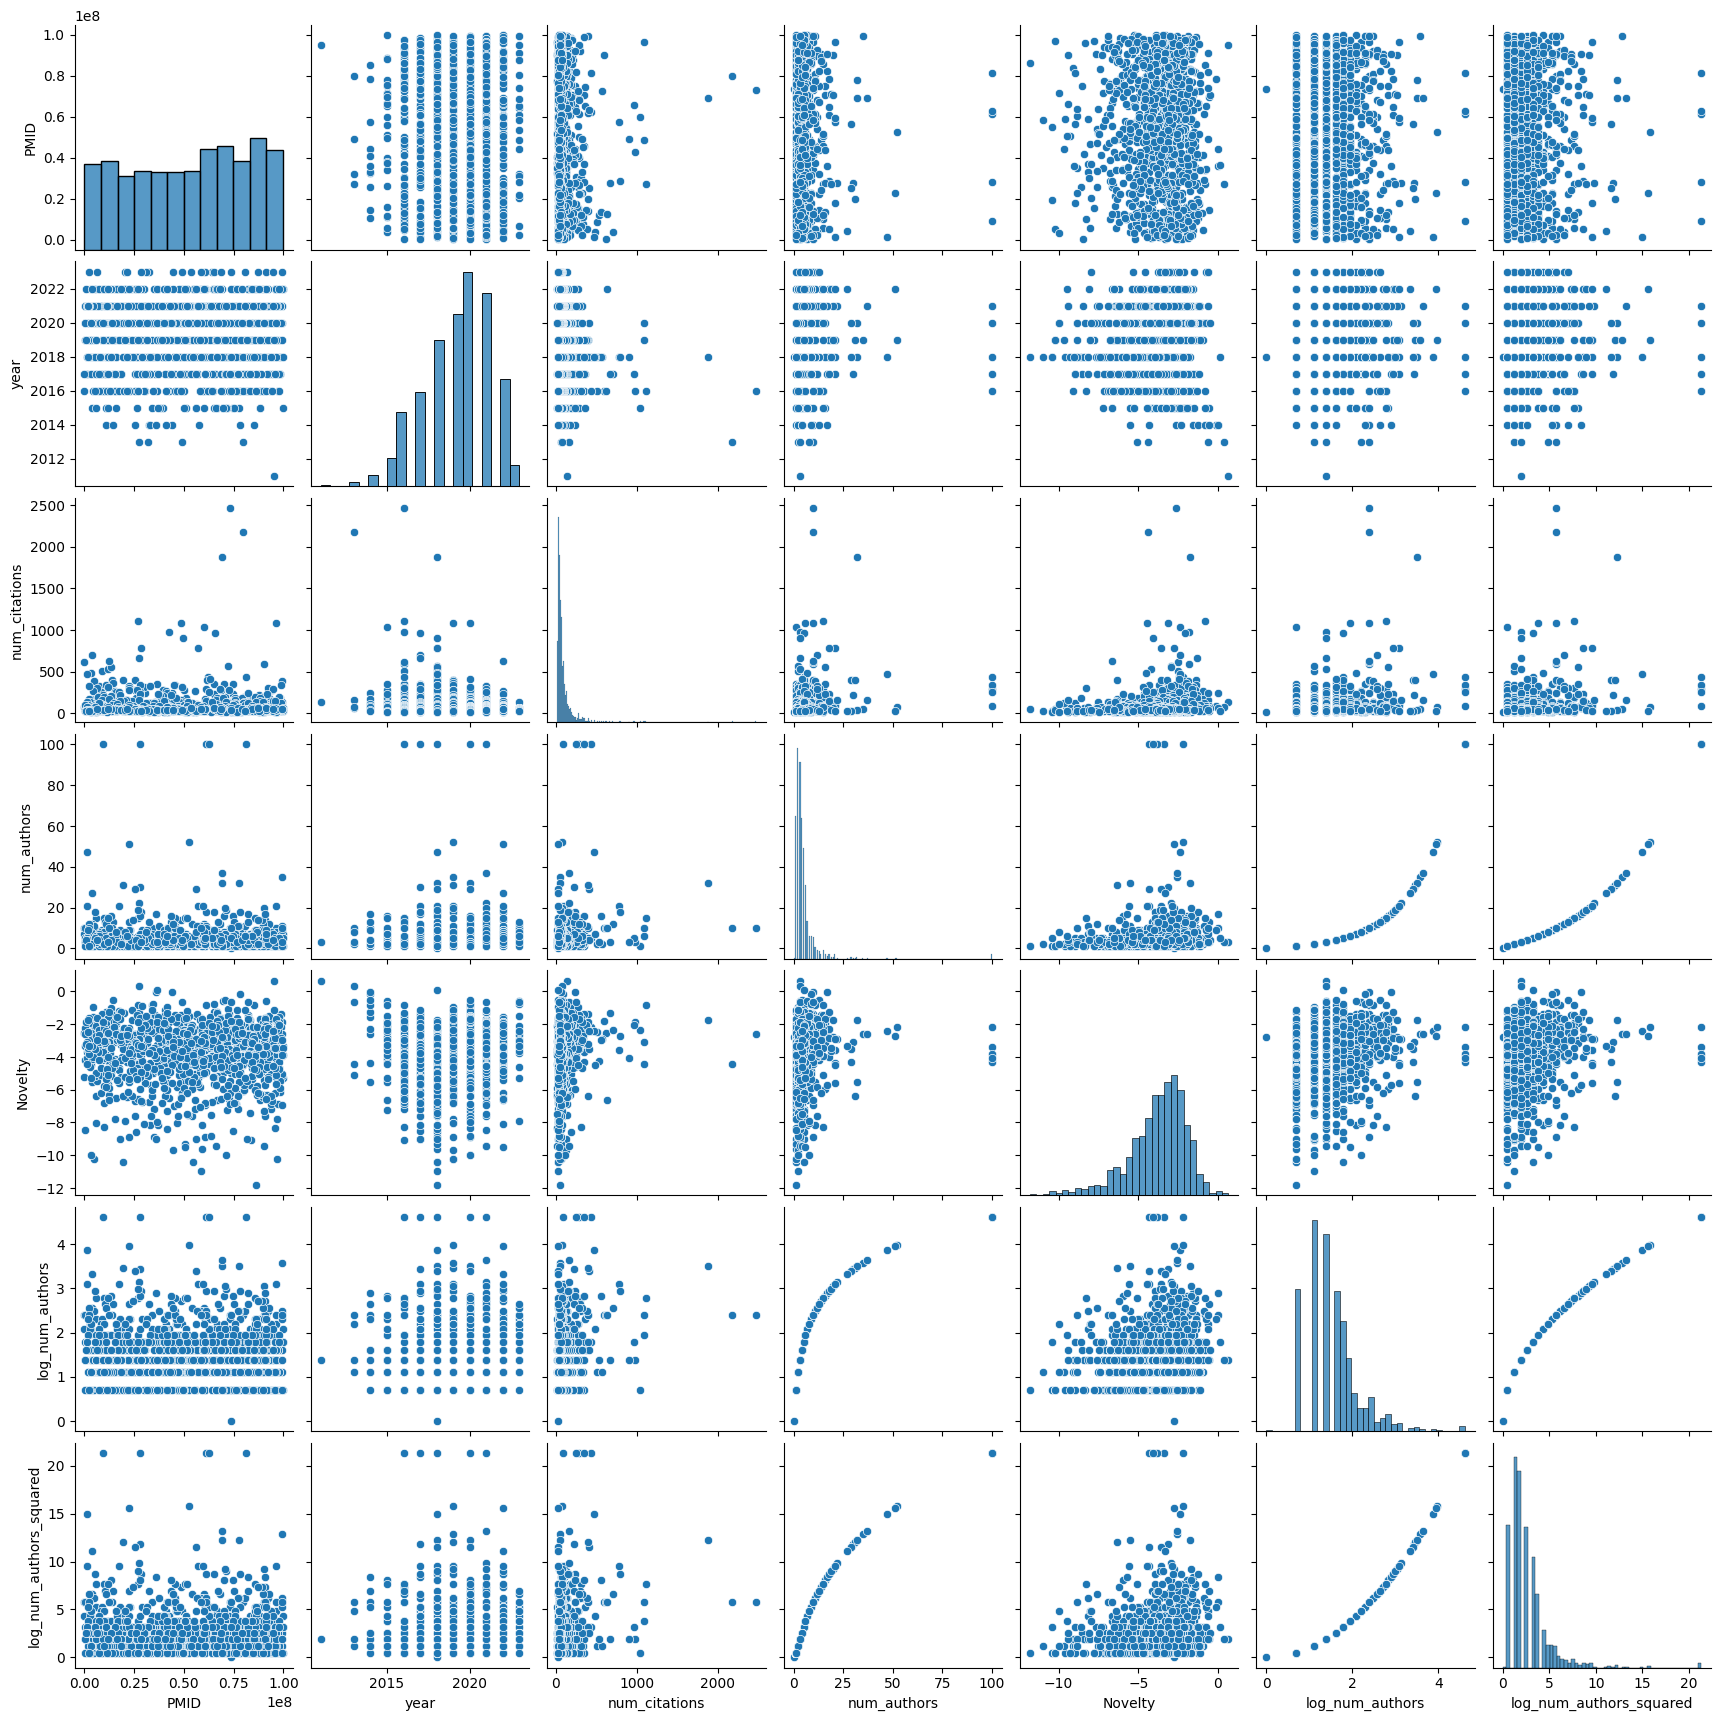

In [28]:
sns.pairplot(df)